<a href="https://colab.research.google.com/github/redwaneaitouammi/AI_Sentiment_Analysis/blob/main/Project3_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment analysis - Based on text classification model

In [34]:
import os
import re
import string
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


Download and explore the IMDB dataset

In [35]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

data = tf.keras.utils.get_file("aclImdb_v1.tar.gz",URL,untar=True,cache_dir='.',cache_subdir='')
data_dir = os.path.join(os.path.dirname(data), 'aclImdb')

In [36]:
os.listdir(data_dir)

['imdbEr.txt', 'imdb.vocab', 'README', 'test', 'train']

In [37]:
train_dir=os.path.join(data_dir,'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt',
 'unsup',
 'neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos']

In [38]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Prepare Data

In [39]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [40]:
batch_size = 32 
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2, 
    subset='training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [41]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("review", text_batch.numpy()[i])
    print("class", label_batch.numpy()[i])

review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
class 0
review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [42]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [43]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [44]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Prepare the dataset for training

 standardize, tokenize, and vectorize the data

 remove punctuation or HTML elements to simplify the dataset

 for example, splitting a sentence into individual words, by splitting on whitespace

 Vectorization refers to converting tokens into numbers so they can be fed into a neural network. 

In [45]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [46]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [47]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In Python, we use the lambda keyword to declare an anonymous function, which is why we refer to them as "lambda functions". An anonymous function refers to a function declared with no name. ... A lambda function can take any number of arguments, but they contain only a single expression.

In [48]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [49]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [50]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [51]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [52]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The model


In [54]:
embedding_dim = 16

In [55]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(max_features+1,embedding_dim),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Loss fuction and optimizer

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

Train the model

In [57]:
Epochs = 15
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs=Epochs
)

Epoch 1/15
625/625 [==============================] - 14s 21ms/step - loss: 0.6828 - binary_accuracy: 0.6117 - val_loss: 0.6154 - val_binary_accuracy: 0.7726
Epoch 2/15
625/625 [==============================] - 5s 8ms/step - loss: 0.5803 - binary_accuracy: 0.7831 - val_loss: 0.4982 - val_binary_accuracy: 0.8204
Epoch 3/15
625/625 [==============================] - 5s 8ms/step - loss: 0.4660 - binary_accuracy: 0.8352 - val_loss: 0.4200 - val_binary_accuracy: 0.8480
Epoch 4/15
625/625 [==============================] - 5s 8ms/step - loss: 0.3908 - binary_accuracy: 0.8610 - val_loss: 0.3737 - val_binary_accuracy: 0.8608
Epoch 5/15
625/625 [==============================] - 5s 8ms/step - loss: 0.3433 - binary_accuracy: 0.8741 - val_loss: 0.3449 - val_binary_accuracy: 0.8680
Epoch 6/15
625/625 [==============================] - 5s 8ms/step - loss: 0.3110 - binary_accuracy: 0.8867 - val_loss: 0.3260 - val_binary_accuracy: 0.8730
Epoch 7/15
625/625 [==============================] - 5s 8ms/s

Evaluate the Model


In [58]:
loss, accuracy = model.evaluate(test_ds)
print(
    "Loss: ", loss
)
print(
    "Accuracy", accuracy
)

782/782 [==============================] - 11s 14ms/step - loss: 0.3116 - binary_accuracy: 0.8737
Loss:  0.3115745782852173
Accuracy 0.8737199902534485


Create a plot of accuracy and loss over time 


In [59]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

 You can use these to plot the training and validation loss for comparison

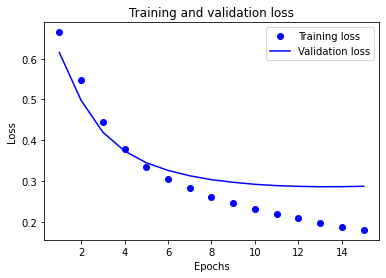

In [60]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'bo', label='Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

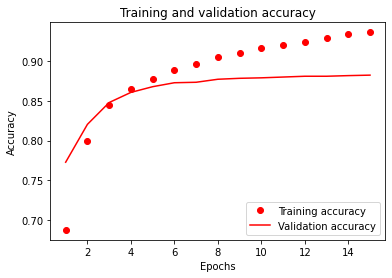

In [61]:
plt.plot(epochs,acc,'ro',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
That's overfitting 

In [62]:
# tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', min_delta=0, patience=0, verbose=0,
#     mode='auto', baseline=None, restore_best_weights=False
# )

you can include the TextVectorization layer inside your model.

In [63]:
model_with_txtVect_layer = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    tf.keras.layers.Activation('sigmoid')
])

model_with_txtVect_layer.compile(
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False), 
    optimizer="adam",
    metrics=['accuracy']
)

loss, accuracy = model_with_txtVect_layer.evaluate(raw_test_ds)

print(accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3133 - accuracy: 0.8739
0.8737199902534485


Inference on new data

In [64]:
examples = [
  "The movie was nice!"  
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
            ]

In [65]:
model_with_txtVect_layer.predict(examples)

array([[0.61988693],
       [0.42302597],
       [0.324687  ]], dtype=float32)